# Programming for Data Science and Artificial Intelligence

## Fashion MNIST with CNN

For these exercises we'll work with the <a href='https://www.kaggle.com/zalando-research/fashionmnist'>Fashion-MNIST</a> dataset, also available through <a href='https://pytorch.org/docs/stable/torchvision/index.html'><tt><strong>torchvision</strong></tt></a>. 

Like MNIST, this dataset consists of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes:
0. T-shirt/top
1. Trouser
2. Pullover
3. Dress
4. Coat
5. Sandal
6. Shirt
7. Sneaker
8. Bag
9. Ankle boot

## 1. ETL

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

transform = transforms.ToTensor()

train_data = datasets.FashionMNIST(root='../Data', train=True, download=True, transform=transform)
test_data  = datasets.FashionMNIST(root='../Data', train=False, download=True, transform=transform)

class_names = ['T-shirt','Trouser','Sweater','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Boot']

100%|██████████| 26421880/26421880 [00:27<00:00, 954339.68it/s] 


Extracting ../Data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../Data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 144635.90it/s]


Extracting ../Data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../Data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:04<00:00, 977976.60it/s] 


Extracting ../Data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../Data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 2450326.49it/s]

Extracting ../Data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../Data/FashionMNIST/raw



### Data loaders

In [3]:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=10, shuffle=False)

## 2. EDA - Examine a batch of images
Use DataLoader, `make_grid` and matplotlib to display the first batch of 10 images.<br>

Label:  [1 2 9 6 8 8 6 2 1 0]
Class:  Trouser Sweater Boot Shirt Bag Bag Shirt Sweater Trouser T-shirt


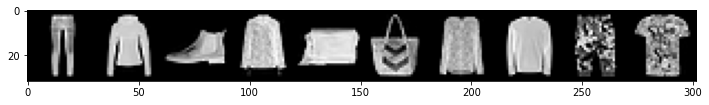

In [5]:
for images,labels in train_loader: 
    break

print('Label: ', labels.numpy())
print('Class: ', *np.array([class_names[i] for i in labels]))

im = make_grid(images, nrow=10)
plt.figure(figsize=(12,4))

plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

## 3. Training / Modeling

Define a CNN model that can be trained on the Fashion-MNIST dataset. The model should contain two convolutional layers, two pooling layers, and two fully connected layers. You can use any number of neurons per layer so long as the model takes in a 28x28 image and returns an output of 10.

In [6]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(5*5*16, 100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 5*5*16)
        X = F.relu(self.fc1(X))
        X = self.fc2(X)
        return F.log_softmax(X, dim=1)
    
torch.manual_seed(101)
model = ConvolutionalNetwork()

### Trainable parameters


$\quad\begin{align}(1\times6\times3\times3)+6+(6\times16\times3\times3)+16+(400\times100)+100+(100\times10)+10 &=\\
54+6+864+16+40000+100+1000+10 &= 42,050\end{align}$

In [7]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

    54
     6
   864
    16
 40000
   100
  1000
    10
______
 42050


### Loss function & optimizer
Cross Entropy Loss and Adam (learning rate of 0.001) respectively.

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Train the model

In [9]:
epochs = 5

for i in range(epochs):
    for X_train, y_train in train_loader:

        # Apply the model
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)

        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'{i+1} of {epochs} epochs completed')

1 of 5 epochs completed
2 of 5 epochs completed
3 of 5 epochs completed
4 of 5 epochs completed
5 of 5 epochs completed


## 4. Inference / Testing

Set `model.eval()` and determine the percentage correct out of 10,000 total test images.

In [10]:
model.eval()

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_loader:
        y_val = model(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
        
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 8812/10000 =  88.120%
